In [1]:
# %matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
train = pd.read_csv('train/train.csv')

In [4]:
train.shape

(52560, 9)

In [5]:
# sns.pairplot(train)

<AxesSubplot:>

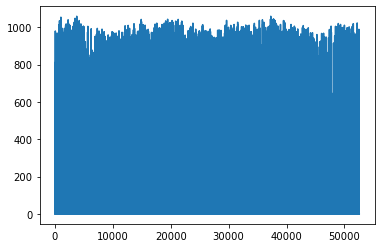

In [6]:
train.DNI.plot()

<AxesSubplot:>

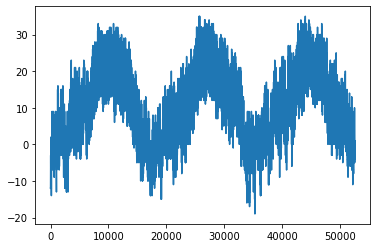

In [7]:
train['T'].plot()

In [8]:
# for _ in range(0, 52560, 48):
#     train.iloc[_:_+48].reset_index()['TARGET'].plot()

In [8]:
train_index = train.set_index(['Day', 'Hour', 'Minute'])

In [9]:
# train_index['Hour'] = train['Hour']

In [131]:
train_index['Day']

KeyError: 'Day'

In [10]:
train_index['HH'] = [_ for __ in range(1095) for _ in range(48) ]

In [11]:
import numpy as np

In [48]:
Y = np.array(train_index['TARGET'])

In [49]:
X = np.array(train_index.drop('TARGET', axis=1))

In [15]:
# !pip install torch

In [16]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

## Dataset

In [113]:
class SlidingDataset_X(Dataset):
    def __init__(self, data_x, window):
        self.data_x = data_x
        self.window = window

    def __getitem__(self, index):
        x = self.data_x[index:index+self.window]

        y = self.data_x[index+self.window+1]
        return x, y 

    def __len__(self):
        return len(self.data_x) - self.window - 1

In [114]:
ds = SlidingDataset_X(X, 24)

In [115]:
dl = DataLoader(ds, batch_size=1024)

In [116]:
for x, y in dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([1024, 24, 6])
torch.Size([1024, 6])


In [117]:
class FCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCN, self).__init__()
        self.hidden_size = hidden_size 
        # nn.Module내의 다른 매개변수는 상속하게 super에서 처리되는데 hidden_size는 없는듯
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) 
        # dim = 1 의 의미 : batch 내에서(한데이터셋 묶음 안에서) softmax를 구한다
        
    def forward(self, input):
        # dim = 1 의 의미 : input과 hidden을 옆으로 붙인다
        # input의 shape는 (bacth_size x input_size)
        # hidden의 shape는 (bacth_size x hidden_size)
        # combined의 shape는 (bacth_size x (input_size + hidden_size))가 된다
        hidden = self.i2h(input)
        hidden = nn.ReLU()(hidden)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output


In [118]:
fcn = FCN(24, 128, 1)

In [119]:
criterion = nn.MSELoss()

In [120]:
import os 
from tqdm import tqdm
os.environ['CUDA_DEVICES_VISIBLE'] = '1'
device = 'cuda: 1'

In [121]:
fcn = fcn.to(device)

In [122]:
optimizer = torch.optim.Adam(fcn.parameters(), lr=0.0001)

In [123]:
loss_list = []
for _ in tqdm(range(20)):
    train_loss = 0.
    for i, batch in enumerate(dl):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        output = fcn(x.transpose(1,2).type(torch.float32))
        loss = criterion(output.type(torch.float64), y.unsqueeze(2))
        loss.backward()
        train_loss += loss
        optimizer.step()
        #if i % 10 == 0:
    loss_list.append(train_loss)

100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


<AxesSubplot:>

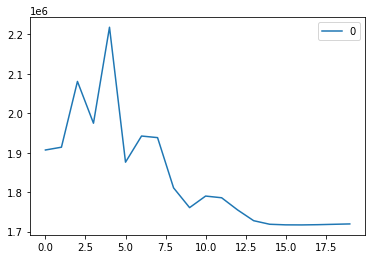

In [124]:
pd.DataFrame([loss.detach().cpu() for loss in loss_list]).plot()

In [66]:
class SlidingDataset_Y(Dataset):
    def __init__(self, data_x, data_y, window):
        self.data_x = data_x
        self.data_y = data_y
        self.window = window

    def __getitem__(self, index):
        x = torch.cat([torch.Tensor(self.data_x[index:index+self.window]), torch.Tensor(self.data_y[index:index+self.window]).unsqueeze(1)], dim=1) 
        y = self.data_y[index+self.window+1]
        return x, y 

    def __len__(self):
        return len(self.data_x) - self.window - 1

In [67]:
# x

In [68]:
ds = SlidingDataset_Y(X, Y, 24)
dl = DataLoader(ds, batch_size=1024)

In [96]:
class FCN_y(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCN_y, self).__init__()
        self.hidden_size = hidden_size 
        # nn.Module내의 다른 매개변수는 상속하게 super에서 처리되는데 hidden_size는 없는듯
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.o2o = nn.Linear(7,output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1) 
        # dim = 1 의 의미 : batch 내에서(한데이터셋 묶음 안에서) softmax를 구한다
        
    def forward(self, input):
        # dim = 1 의 의미 : input과 hidden을 옆으로 붙인다
        # input의 shape는 (bacth_size x input_size)
        # hidden의 shape는 (bacth_size x hidden_size)
        # combined의 shape는 (bacth_size x (input_size + hidden_size))가 된다
        hidden = self.i2h(input)
        hidden = self.relu(hidden)
        output = self.h2o(hidden)
        output = self.softmax(output)
        output = self.o2o(output.squeeze(2))
        output = self.relu(output)

        return output

In [104]:
fcn_y = FCN_y(24, 128, 1).to(device)
optimizer = torch.optim.Adam(fcn_y.parameters(), lr=0.00001)
loss_list = []
for _ in tqdm(range(20)):
    train_loss = 0.
    for i, batch in enumerate(dl):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        output = fcn_y(x.transpose(1,2).type(torch.float32))
        # print(output.shape, y.shape)
        loss = criterion(output.type(torch.float64), y.unsqueeze(1).type(torch.float64))
        loss.backward()
        optimizer.step()
        train_loss += loss
    loss_list.append(train_loss)

100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


<AxesSubplot:>

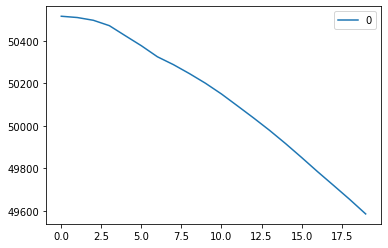

In [105]:
pd.DataFrame([loss.detach().cpu() for loss in loss_list]).plot()

In [128]:
df.shape

(336, 9)

In [130]:
df = pd.read_csv('test/0.csv')
df['HH'] = [_ for __ in range(7) for _ in range(48)]


In [ ]:
class FCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCN, self).__init__()
        self.hidden_size = hidden_size 
        # nn.Module내의 다른 매개변수는 상속하게 super에서 처리되는데 hidden_size는 없는듯
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) 
        # dim = 1 의 의미 : batch 내에서(한데이터셋 묶음 안에서) softmax를 구한다
        
    def forward(self, input):
        # dim = 1 의 의미 : input과 hidden을 옆으로 붙인다
        # input의 shape는 (bacth_size x input_size)
        # hidden의 shape는 (bacth_size x hidden_size)
        # combined의 shape는 (bacth_size x (input_size + hidden_size))가 된다
        hidden = self.i2h(input)
        hidden = self.softmax(hidden)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output


In [40]:
1class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size 
        # nn.Module내의 다른 매개변수는 상속하게 super에서 처리되는데 hidden_size는 없는듯
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) 
        # dim = 1 의 의미 : batch 내에서(한데이터셋 묶음 안에서) softmax를 구한다
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        # dim = 1 의 의미 : input과 hidden을 옆으로 붙인다
        # input의 shape는 (bacth_size x input_size)
        # hidden의 shape는 (bacth_size x hidden_size)
        # combined의 shape는 (bacth_size x (input_size + hidden_size))가 된다
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        ddddreturn torch.zeros(1, self.hidden_size)


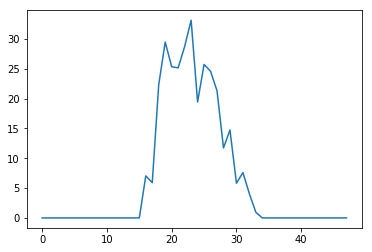

In [15]:
train['TARGET'].iloc[:48].plot()

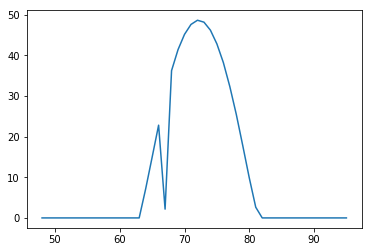

In [17]:
train['TARGET'].iloc[48:48+48].plot()

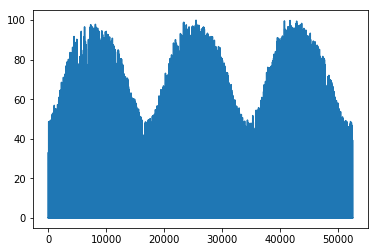

In [12]:
train['TARGET'].plot()